#### PART 1 : Load the recordings, find artefacts, resync ####

**Import all the librairies and functions**

In [2]:
# Importation of librairies and functions
import os
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
# check some package versions for documentation and reproducibility
import sys
import mne
from matplotlib import __version__ as plt_version
import scipy
print('Python sys', sys.version)
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('mne', mne.__version__)
print('sci-py', scipy.__version__)
print('matplotlib', plt_version)

Python sys 3.10.9 | packaged by conda-forge | (main, Feb  2 2023, 20:14:58) [MSC v.1929 64 bit (AMD64)]
pandas 1.5.3
numpy 1.23.5
mne 1.3.0
sci-py 1.10.0
matplotlib 3.6.3


In [4]:
def set_cd_repo_folder():
    """sets current working directory to main repo folder"""
    cd = os.getcwd()

    check = 0

    while os.path.basename(cd) != 'ReSync':

        cd = os.path.dirname(cd)
        check += 1
        if check > 10: raise ValueError('Repo path not found')
    
    os.chdir(cd)

    print(f'working directory changed to {os.getcwd()}')

    return os.getcwd()


In [5]:
project_path = set_cd_repo_folder()

working directory changed to c:\Users\Juliette\Research\Projects\Synchronization_project\Code\ReSync


In [6]:
# import custom-made functions
import functions.preprocessing as preproc
import functions.utils as utils
import functions.plotting as plot
import functions.find_artefacts as artefact
import functions.crop as crop
import functions.main_resync as resync

In [13]:
importlib.reload(plot)
importlib.reload(preproc)
importlib.reload(utils)
importlib.reload(artefact)
importlib.reload(crop)
importlib.reload(resync)

<module 'functions.main_resync' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization_project\\Code\\ReSync\\functions\\main_resync.py'>

**Load your own LFP data:**

Resulting variables needed for subsequent analysis:
- LFP_array (np.ndarray, multi dimensional): the LFP recording which has to be aligned, containing all channels
- lfp_sig (np.ndarray, 1d): the channel containing the LFP signal from the hemisphere where the stimulation was delivered to create artefacts
- sf_LFP (int): the sampling frequency of the LFP signal
- LFP_rec_ch_names (list): names of all the channels, in a list (will be used to annotate cropped recording)


In [7]:
# load pyPerceive functions
os.chdir(os.path.dirname(os.getcwd()))
os.chdir(os.path.join(os.getcwd(), 'PyPerceive'))
os.chdir(os.path.join(os.getcwd(), 'code'))
pyPerceive_path = os.getcwd()
print (f'working dir to go fetch PyPerceive functions:{pyPerceive_path}')

from PerceiveImport.classes import (
    main_class, modality_class, metadata_class,
    session_class, condition_class, task_class,
    contact_class, run_class
)
import PerceiveImport.methods.load_rawfile as load_rawfile
import PerceiveImport.methods.find_folders as find_folders
import PerceiveImport.methods.metadata_helpers as metaHelpers

#reset the proper working directory for the analysis
os.chdir(project_path)
print (f'working dir set back to:{project_path}')

working dir to go fetch PyPerceive functions:c:\Users\Juliette\Research\Projects\Synchronization_project\Code\PyPerceive\code
working dir set back to:c:\Users\Juliette\Research\Projects\Synchronization_project\Code\ReSync


In [8]:
# choose LFP file
sub048 = main_class.PerceiveData(
    sub = "048", 
    incl_modalities=['streaming'],
    incl_session = ["fu12m"],
    incl_condition =['m0s0','m0s1','m1s0','m1s1'],
    incl_task = ["rest"],
    # incl_contact = ["RingL", "SegmInterR", "SegmIntraR"],
    import_json=False,
    warn_for_metaNaNs=True,
    allow_NaNs_in_metadata=False
)

# define LFP data
LFP_rec = sub048.streaming.fu12m.m0s0.rest.run1.data
LFP_array = LFP_rec.get_data()
ch_i = 0 #choose index of the channel containing the stim artefacts (O for left hemisphere, 1 for right hemisphere)
lfp_sig = LFP_rec.get_data()[ch_i]
LFP_rec_ch_names = LFP_rec.ch_names
#sf_LFP = round(LFP_rec.info['sfreq']) will be deleted and put in settings

n_chan = len(LFP_rec.ch_names)
time_duration_LFP = (LFP_rec.n_times/LFP_rec.info['sfreq']).astype(float)
print(     
	f'The data object has:\n\t{LFP_rec.n_times} time samples,'      
	f'\n\tand a sample frequency of {LFP_rec.info["sfreq"]} Hz'      
	f'\n\twith a recording duration of {time_duration_LFP} seconds.'      
	f'\n\t{n_chan} channels were labeled as \n{LFP_rec.ch_names}.')
print(f'The channel containing artefacts has index {ch_i} and is named {LFP_rec.ch_names[ch_i]}')


	### WARNING: NaNs in Metadata Table sub-048 ###
NaNs in: sub-20220530PStn_ses-2023060807082685_run-IS20230608072000.mat
NaNs in: sub-20220530PStn_ses-2023060809351485_run-IS20230608095000.mat
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=67500
    Range : 0 ... 67499 =      0.000 ...   269.996 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=224188
    Range : 0 ... 224187 =      0.000 ...   896.748 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=70500
    Range : 0 ... 70499 =      0.000 ...   281.996 secs
Ready.
add run 1
Creating RawArray with float64 data, n_channels=6, n_times=213500
    Range : 0 ... 213499 =      0.000 ...   853.996 secs
Ready.
The data object has:
	67500 time samples,
	and a sample frequency of 250.0 Hz
	with a recording duration of 270.0 seconds.
	6 channels were labeled as 
['LFP_L_13_STN_MT', 'LFP_R_02_STN_MT', 'LFP_L_13_STN_MT_PEAK15Hz_THR20-30_AVG3000ms', 'LFP_R_02_ST

**Load your own external data:**
(our external data recorder is a TMSi Data recorder.)

PM: NOTICE THE POP UP WINDOW AFTER RUNNING, TO SELECT THE FILE LOCATION

Resulting variables:
- BIP_channel (np.ndarray, 1d): the channel containing the signal from the bipolar electrode used to pick up the artefacts on the IPG/cable
- external_file (np.ndarray, multi-dimensional): the complete external recording containing all channels recorded
- external_rec_ch_names (list, same length as the number of channels in external_file): list of the channels names, to rename them accordingly after alignment

In [9]:
import functions.tmsi_poly5reader as poly5_reader
import functions.loading_TMSi as loading

In [12]:
importlib.reload(loading)

<module 'functions.loading_TMSi' from 'c:\\Users\\Juliette\\Research\\Projects\\Synchronization_project\\Code\\ReSync\\functions\\loading_TMSi.py'>

In [13]:
TMSi_data = poly5_reader.Poly5Reader()  # open TMSi data from poly5
(BIP_channel,
 external_file,
 external_rec_ch_names) = loading.load_TMSi_artefact_channel(TMSi_data) # function adapted for our own data recorder, 
# to load all necessary variables

Reading file  C:/Users/Juliette/OneDrive - Charité - Universitätsmedizin Berlin/Recordings/TMSi files/sub-048/12MFU/sub048_12mfu_M0S0_BrStr_RestTap - 20230608T093010/sub048_12mfu_M0S0_BrStr_RestTap-20230608T093010.DATA.Poly5
	 Number of samples:  1168895 
	 Number of channels:  9 
	 Sample rate: 4000 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=9, n_times=1168895
    Range : 0 ... 1168894 =      0.000 ...   292.224 secs
Ready.
The data object has:
	1168895 time samples,
	and a sample frequency of 4000.0 Hz
	with a recording duration of 292.22375 seconds.
	9 channels were labeled as 
['BIP 01', 'X-0', 'Y-0', 'Z-0', 'X-1', 'Y-1', 'Z-1', 'STATUS', 'Counter 2power24'].
the channel used to align datas is the channel named BIP 01 and has index 0


Reading file  C:/Users/Juliette/OneDrive - Charité - Universitätsmedizin Berlin/Recordings/TMSi files/sub-055/12MFU/sub055_12MFU_M1S0_BrStr_RestTap - 20230803T144725.DATA.Poly5
	 Number of samples:  758095 
	 Number of channels:  38 
	 Sample rate: 2048 Hz
Done reading data.
Creating RawArray with float64 data, n_channels=38, n_times=758095
    Range : 0 ... 758094 =      0.000 ...   370.163 secs
Ready.


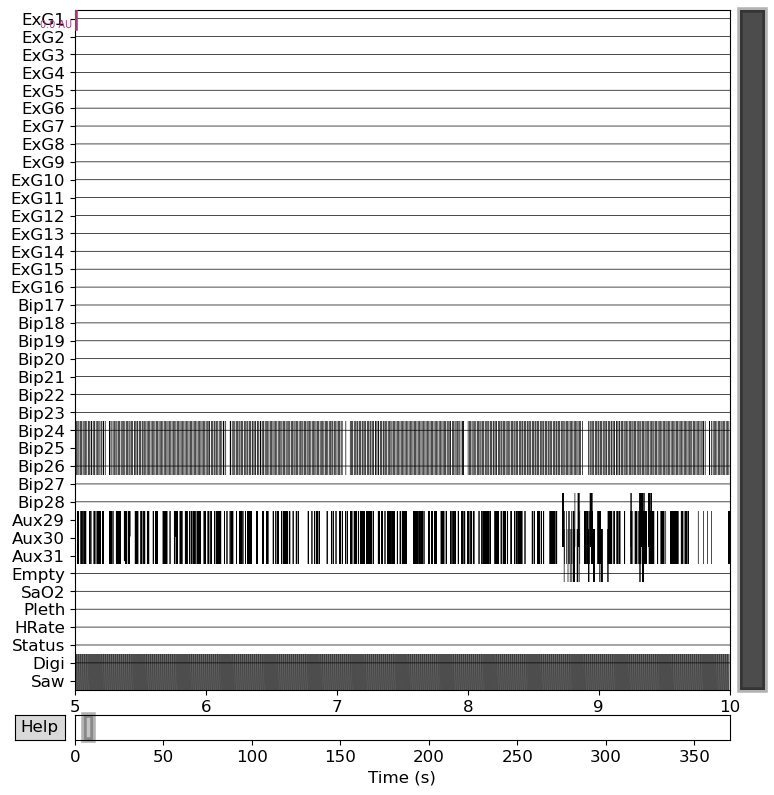

['ExG1', 'ExG2', 'ExG3', 'ExG4', 'ExG5', 'ExG6', 'ExG7', 'ExG8', 'ExG9', 'ExG10', 'ExG11', 'ExG12', 'ExG13', 'ExG14', 'ExG15', 'ExG16', 'Bip17', 'Bip18', 'Bip19', 'Bip20', 'Bip21', 'Bip22', 'Bip23', 'Bip24', 'Bip25', 'Bip26', 'Bip27', 'Bip28', 'Aux29', 'Aux30', 'Aux31', 'Empty', 'SaO2', 'Pleth', 'HRate', 'Status', 'Digi', 'Saw']


In [27]:
%matplotlib inline

import functions.tmsi_poly5reader as poly5_reader
import functions.loading_TMSi as loading

TMSi_data = poly5_reader.Poly5Reader()  # open TMSi data from poly5
toMNE = True
TMSi_file = TMSi_data.read_data_MNE()
 
info_mne = TMSi_file.info
samples_mne = TMSi_file._data
ch_names = TMSi_file.ch_names

TMSi_file.plot(start = 5, duration = 5, n_channels = 40) #(only if I want to plot in interactive viewer)
print(ch_names)

**Align recordings:**

In [24]:
a = 8

# if a > 5:
#     raise ValueError('PRINT ERROR')

# assert a == 8, 'A IS NOT 8'


try:
    # import somethign
    a = [8,4,3,3,2]
    assert a == 8, 'A IS NOT 8'

except ValueError:  # AssertionError
    print('catched')

AssertionError: A IS NOT 8

In [30]:
(LFP_df_offset, 
 external_df_offset) = resync.run_resync(
    LFP_array=LFP_array,
    lfp_sig=lfp_sig,
    LFP_rec_ch_names=LFP_rec_ch_names,
    external_file=external_file,
    BIP_channel=BIP_channel,
    external_rec_ch_names=external_rec_ch_names,
    SHOW_FIGURES = False
)

signal is inverted
1130 1095


#### PART 2 : Look for timeshift ####

In [11]:
timeshift = resync.run_timeshift_analysis(
    LFP_df_offset,
    external_df_offset,
    SHOW_FIGURES = False
)

timeshift

3.4999999999740794